<a href="https://colab.research.google.com/github/ghimiresushma99/links/blob/main/POIswithinKathmandu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import geopandas as gpd
import hashlib

In [ ]:
def generate_hash():
    secret_key = '!9B@AB2alSM@y73sec(87$%8'
    message = "Source=Validation_Wizard"
    combined = secret_key + message
    # Encode the combined string
    encoded = combined.encode("utf-8")
    hashed = hashlib.sha256(encoded).hexdigest()
    return hashed

In [ ]:
class ReadPluckerData:
    def __init__(self, bbox):
        """Class to read map data within bbox even if the file is not provided.

        Parameter:
        ---------
        bbox : bounding box
        """
        self.bbox = bbox

    def get_plucker_data(self):
        """Function to read the map data within the bbox

        Return:
        -------
        XML : returns map data in xml format
        """
        hashed = generate_hash()
        plucker_url = (
            'https://vidya.klldev.org'
            + "/api/v1/poi/public/validate?bbox="
            + self.bbox
            + "&key="
            + hashed
        )
        response = requests.get(plucker_url)

        if response.status_code == 200:
            return response.json()
        else:
            error_message = f"Error: {response.status_code}"
            if response.text:
                error_message += f", Response: {response.text}"
            raise Exception(error_message)

    def dataframe_plucker_data(self, json_data):
        """Function to read the json format data and return dataframe

        Parameter:
        ----------
        json_data: plucker data in json_format

        Return:
        -------
        df : Dataframe
        """
        df = pd.DataFrame(json_data)
        if df.empty:
            return df
        else:
            df.rename(columns={"geom": "geometry"}, inplace=True)
            selected_columns = ["id", "tags", "geometry"]
            new_df = df[selected_columns]
            new_df["geometry"] = new_df["geometry"].apply(lambda x: Point(x[0], x[1]))
            new_df["source"] = "plucker"
            new_df["type"] = "node"
            return new_df

In [ ]:
class ReadContributionData:
    def __init__(self, bbox):
        self.bbox = bbox

    def read_bbox_data(self):
        url = (
            'https://contributions.baato.io'
            + "/api/v1/contributions/validate?bbox="
            + self.bbox
        )
        hashed = generate_hash()
        headers = {"Authorization": hashed}
        response = requests.get(url, headers=headers)
        data = response.json()
        df = pd.DataFrame(data)
        if df.empty:
            return df
        else:
            df.rename(columns={"geom": "geometry"}, inplace=True)
            selected_columns = ["id", "tags", "geometry"]
            new_df = df[selected_columns]
            new_df["geometry"] = new_df["geometry"].apply(lambda x: Point(x[0], x[1]))
            new_df["source"] = "contribution"
            new_df["type"] = "node"
            return new_df

In [ ]:
class ReadBBOXData:
    def __init__(self, bbox):
        """Class to read map data within bbox even if the file is not provided.

        Parameter:
        ---------
        bbox : bounding box
        """
        self.bbox = bbox

    def get_osm_data(self):
        """Function to read the map data within the bbox

        Return:
        -------
        XML : returns map data in xml format
        """
        if isinstance(self.bbox, list):
            self.bbox = ",".join(map(str, self.bbox))
        api_url = 'https://osm.klldev.org' + "/api/0.6/map?bbox=" + self.bbox
        response = requests.get(api_url)

        if response.status_code == 200:
            return response.content
        else:
            error_message = f"Error: {response.status_code}"
            if response.text:
                error_message += f", Response: {response.text}"
            raise Exception(error_message)

    def parse_osm_data(self, xml_data):
        """Function to parse the xml data and return the data in well formatted list form

        Parameter:
        ----------
        xml_data: map data in xml format

        Return:
        -------
        data : List of map data
        """
        root = ET.fromstring(xml_data)

        data = []
        nodes = {}
        ways = {}
        for element in root.findall(".//node"):
            node_id = element.get("id")
            geometry = Point(float(element.get("lon")), float(element.get("lat")))
            node_data = {
                "id": node_id,
                "type": "node",
                "geometry": geometry,
                "tags": {tag.get("k"): tag.get("v") for tag in element.findall("tag")}
                if element.findall("tag")
                else None,
                "source": "OSM",
            }
            if node_data["geometry"] is not None and node_data["tags"] is not None:
                data.append(node_data)
            nodes[node_id] = geometry

        for element in root.findall(".//way"):
            element_data = {
                "id": element.get("id"),
                "type": "way",
                "geometry": [],  # Initialize an empty list for way geometry
                "tags": {tag.get("k"): tag.get("v") for tag in element.findall("tag")}
                if element.findall("tag")
                else None,
                "source": "OSM",
            }

            # Extract geometry from nodes
            for nd_ref in element.findall("nd"):
                node_id = nd_ref.get("ref")
                if node_id in nodes:
                    element_data["geometry"].append(nodes[node_id])

            # Convert the list of coordinates to a LineString
            line_string = LineString(element_data["geometry"])
            element_data["geometry"] = line_string

            if element_data["geometry"] is not None and element_data["tags"] is not None:
                data.append(element_data)
            ways[element.get("id")] = element_data["geometry"]

        for element in root.findall(".//relation"):
            element_data = {
                "id": element.get("id"),
                "type": "relation",
                "geometry": [],
                "tags": {tag.get("k"): tag.get("v") for tag in element.findall("tag")}
                if element.findall("tag")
                else None,
                "source": "OSM",
            }

            for member in element.findall("member"):
                member_type = member.get("type")
                member_ref = member.get("ref")
                member_role = member.get("role")

                member_data = {
                    "type": member_type,
                    "ref": member_ref,
                    "role": member_role,
                    "geometry": None
                }

                if member_type == "node" and member_ref in nodes:
                    member_data["geometry"] = nodes[member_ref]
                elif member_type == "way" and member_ref in ways:
                    member_data["geometry"] = ways[member_ref]

                element_data["geometry"].append(member_data['geometry'])

            if element_data["geometry"] and element_data["tags"]:
                data.append(element_data)

        return data

In [ ]:
class ReadWardData:
    def __init__(self, ward):
        self.ward = ward

    def read_ward_data(self):
        api = (
            'http://143.110.245.175:3000'
            + "/api/v1/boundaries?adminLevel=municipalities&name="
            + self.ward
        )
        print(api)
        response = requests.get(api)
        data = response.json()
        geometry = data["geometry"]["coordinates"]
        flat_coordinates = [coord for sublist in geometry for coord in sublist]
        geometry_tuples = [(x, y) for x, y in flat_coordinates]
        gdf_polygon = gpd.GeoDataFrame(geometry=[Polygon(geometry_tuples)])
        bbox_size = 0.005
        bboxes = []
        minx, miny, maxx, maxy = gdf_polygon.total_bounds
        current_x = minx
        while current_x < maxx:
            current_y = miny
            while current_y < maxy:
                bbox = [
                    float(current_x),
                    float(current_y),
                    float(current_x + bbox_size),
                    float(current_y + bbox_size),
                ]
                if Polygon(
                    [
                        (bbox[0], bbox[1]),
                        (bbox[2], bbox[1]),
                        (bbox[2], bbox[3]),
                        (bbox[0], bbox[3]),
                    ]
                ).intersects(gdf_polygon["geometry"].iloc[0]):
                    bboxes.append(bbox)
                current_y += bbox_size
            current_x += bbox_size
        self.df = pd.DataFrame()
        for bbox in bboxes:
            bbox = ",".join(map(str, bbox))
            bbox_data = ReadBBOXData(bbox)
            osm_data = bbox_data.get_osm_data()
            osm_data_list = bbox_data.parse_osm_data(osm_data)
            df = pd.DataFrame(osm_data_list)
            if df.empty:
                continue
            else:
                df["tags"] = df["tags"].apply(lambda x: {} if x is None else x)

                # Concatenate to the final DataFrame
                self.df = pd.concat([self.df, df], ignore_index=True)

        return self.df

In [ ]:
ward = input(str("Enter ward:"))

Enter ward:Kathmandu


In [ ]:
ward_data = ReadWardData(ward)
df = ward_data.read_ward_data()

http://143.110.245.175:3000/api/v1/boundaries?adminLevel=municipalities&name=Kathmandu


In [ ]:
df

,id,type,geometry,tags,source
0,360464983,node,POINT (85.2841203 27.689237),"{'name': 'Khasibazaar', 'public_transport': 's...",OSM
1,3144311241,node,POINT (85.2813865 27.6879276),"{'material': 'steel', 'power': 'tower'}",OSM
2,3144311247,node,POINT (85.2798692 27.6920291),{'power': 'tower'},OSM
3,3155908387,node,POINT (85.2795952 27.692695),"{'amenity': 'atm', 'name': 'Everest bank ATM',...",OSM
4,4396927189,node,POINT (85.2828665 27.6905661),"{'amenity': 'cafe', 'name:en': 'Amit Ankit Kha...",OSM
...,...,...,...,...,...
228019,12394677,relation,"[None, None, LINESTRING (85.3450523 27.7502173...","{'admin_level': '7', 'boundary': 'administrati...",OSM
228020,4583125,relation,"[None, None, None, None, None, None, LINESTRIN...","{'admin_level': '8', 'capital': 'yes', 'is_in:...",OSM
228021,12394682,relation,"[LINESTRING (85.371182 27.735503, 85.3735328 2...","{'admin_level': '7', 'boundary': 'administrati...",OSM
228022,16106454,relation,"[None, None, LINESTRING (85.3814935 27.7639122...","{'boundary': 'place', 'name': 'Kapan', 'place'...",OSM


In [ ]:
df['source'] = 'int_OSM'

In [ ]:
df = df[df['tags']!= {}]

In [ ]:
df

,id,type,geometry,tags,source
0,360464983,node,POINT (85.2841203 27.689237),"{'name': 'Khasibazaar', 'public_transport': 's...",int_OSM
1,3144311241,node,POINT (85.2813865 27.6879276),"{'material': 'steel', 'power': 'tower'}",int_OSM
2,3144311247,node,POINT (85.2798692 27.6920291),{'power': 'tower'},int_OSM
3,3155908387,node,POINT (85.2795952 27.692695),"{'amenity': 'atm', 'name': 'Everest bank ATM',...",int_OSM
4,4396927189,node,POINT (85.2828665 27.6905661),"{'amenity': 'cafe', 'name:en': 'Amit Ankit Kha...",int_OSM
...,...,...,...,...,...
228019,12394677,relation,"[None, None, LINESTRING (85.3450523 27.7502173...","{'admin_level': '7', 'boundary': 'administrati...",int_OSM
228020,4583125,relation,"[None, None, None, None, None, None, LINESTRIN...","{'admin_level': '8', 'capital': 'yes', 'is_in:...",int_OSM
228021,12394682,relation,"[LINESTRING (85.371182 27.735503, 85.3735328 2...","{'admin_level': '7', 'boundary': 'administrati...",int_OSM
228022,16106454,relation,"[None, None, LINESTRING (85.3814935 27.7639122...","{'boundary': 'place', 'name': 'Kapan', 'place'...",int_OSM


In [ ]:
df_osm = df[df['source'] == 'OSM']

In [ ]:
df_plucker = df[df['source'] == 'plucker']

In [ ]:
df_contribution = df[df['source'] == 'contribution']

In [ ]:
df_osm.shape

(226055, 5)

In [ ]:
df_plucker.shape

(54281, 5)

In [ ]:
df_contribution.shape

(861, 5)

In [ ]:
osm_data = []

In [ ]:
for _, row in df.iterrows():
    for key, value in row['tags'].items():
        if key == 'name' or key.startswith('name'):
            osm_data.append(row)

In [ ]:
osm_df = pd.DataFrame(osm_data)

In [ ]:
osm_df = osm_df.drop_duplicates(subset=['id'])

In [ ]:
osm_df

,id,type,geometry,tags,source
0,360464983,node,POINT (85.2841203 27.689237),"{'name': 'Khasibazaar', 'public_transport': 's...",int_OSM
3,3155908387,node,POINT (85.2795952 27.692695),"{'amenity': 'atm', 'name': 'Everest bank ATM',...",int_OSM
4,4396927189,node,POINT (85.2828665 27.6905661),"{'amenity': 'cafe', 'name:en': 'Amit Ankit Kha...",int_OSM
5,4928062818,node,POINT (85.2827014 27.690429),"{'addr:city': 'Kathmandu Municipality', 'addr:...",int_OSM
8,5543530921,node,POINT (85.2832512 27.6926344),"{'addr:street': 'Sanrachana Marg', 'name:en': ...",int_OSM
...,...,...,...,...,...
227466,9722113420,node,POINT (85.3715969 27.7336531),"{'amenity': 'place_of_worship', 'name': 'श्री ...",int_OSM
227467,9722113421,node,POINT (85.3714849 27.7334568),"{'amenity': 'driving_school', 'name:en': 'Hela...",int_OSM
227468,11053841128,node,POINT (85.3710807 27.7367781),"{'addr:dist': 'Gorkha', 'addr:mun': 'Aarughat ...",int_OSM
227469,6237548986,node,POINT (85.3699944 27.7337957),"{'name': 'GNKR', 'name:en': 'GNKR', 'tourism':...",int_OSM


In [ ]:
other_osm_df = osm_df[osm_df['type']!='relation']

In [ ]:
relation_df = osm_df[osm_df['type']=='relation']

In [ ]:
api = "http://143.110.245.175:3000/api/v1/boundaries?adminLevel=municipalities&name=" + ward
response = requests.get(api)
data = response.json()
geom = data["geometry"]["coordinates"]
flat_coordinates = [coord for sublist in geom for coord in sublist]

In [ ]:
polygon = Polygon(flat_coordinates)

In [ ]:
other_osm_df = other_osm_df[other_osm_df["geometry"].apply(lambda point: point.within(polygon))]

In [ ]:
other_osm_df

,id,type,geometry,tags,source
8,5543530921,node,POINT (85.2832512 27.6926344),"{'addr:street': 'Sanrachana Marg', 'name:en': ...",int_OSM
89,172348748,way,"LINESTRING (85.2841909 27.6939404, 85.2842286 ...","{'highway': 'residential', 'name': 'B. P. Marg'}",int_OSM
105,184873309,way,"LINESTRING (85.2841013 27.6924681, 85.2844213 ...","{'highway': 'residential', 'name': 'Hatti Galli'}",int_OSM
855,1497177900,node,POINT (85.2812198 27.6953241),"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",int_OSM
858,1885423422,node,POINT (85.2821442 27.694123),"{'amenity': 'police', 'name': 'Traffic Station'}",int_OSM
...,...,...,...,...,...
226862,519902244,way,"LINESTRING (85.3700956 27.7295682, 85.370415 2...","{'building': 'yes', 'name': 'Todddler Int'l Pr...",int_OSM
227463,9722113224,node,POINT (85.3715762 27.7331252),"{'amenity': 'school', 'name': 'युनिकेयर बाल स्...",int_OSM
227464,9722113318,node,POINT (85.3728238 27.7328736),"{'amenity': 'school', 'name': 'आधारशिला विद्या...",int_OSM
227466,9722113420,node,POINT (85.3715969 27.7336531),"{'amenity': 'place_of_worship', 'name': 'श्री ...",int_OSM


In [ ]:
relation_data = []

In [ ]:
for _, row in relation_df.iterrows():
    if 'boundary' in row['tags'] or 'admin_level' in row['tags'] or 'route' in row['tags'] or 'waterway' in row['tags']:
        continue
    else:
      relation_data.append(row)

In [ ]:
relation_df = pd.DataFrame(relation_data)

In [ ]:
relation_df = relation_df.drop_duplicates(subset=['id'])

In [ ]:
relation_df.shape

(60, 5)

In [ ]:
other_osm_df = other_osm_df[other_osm_df["geometry"].apply(lambda point: point.within(polygon))]

In [ ]:
other_osm_df

,id,type,geometry,tags,source
8,5543530921,node,POINT (85.2832512 27.6926344),"{'addr:street': 'Sanrachana Marg', 'name:en': ...",int_OSM
89,172348748,way,"LINESTRING (85.2841909 27.6939404, 85.2842286 ...","{'highway': 'residential', 'name': 'B. P. Marg'}",int_OSM
105,184873309,way,"LINESTRING (85.2841013 27.6924681, 85.2844213 ...","{'highway': 'residential', 'name': 'Hatti Galli'}",int_OSM
855,1497177900,node,POINT (85.2812198 27.6953241),"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",int_OSM
858,1885423422,node,POINT (85.2821442 27.694123),"{'amenity': 'police', 'name': 'Traffic Station'}",int_OSM
...,...,...,...,...,...
226862,519902244,way,"LINESTRING (85.3700956 27.7295682, 85.370415 2...","{'building': 'yes', 'name': 'Todddler Int'l Pr...",int_OSM
227463,9722113224,node,POINT (85.3715762 27.7331252),"{'amenity': 'school', 'name': 'युनिकेयर बाल स्...",int_OSM
227464,9722113318,node,POINT (85.3728238 27.7328736),"{'amenity': 'school', 'name': 'आधारशिला विद्या...",int_OSM
227466,9722113420,node,POINT (85.3715969 27.7336531),"{'amenity': 'place_of_worship', 'name': 'श्री ...",int_OSM


In [ ]:
df_plucker = df_plucker[df_plucker["geometry"].apply(lambda point: point.within(polygon))]

In [ ]:
df_contribution = df_contribution[df_contribution["geometry"].apply(lambda point: point.within(polygon))]

In [ ]:
df_plucker.shape

(49237, 5)

In [ ]:
df_contribution.shape

(746, 5)

In [ ]:
way_osm_df = other_osm_df[other_osm_df['type'] == 'way']

In [ ]:
way_osm_df

,id,type,geometry,tags,source
89,172348748,way,"LINESTRING (85.2841909 27.6939404, 85.2842286 ...","{'highway': 'residential', 'name': 'B. P. Marg'}",int_OSM
105,184873309,way,"LINESTRING (85.2841013 27.6924681, 85.2844213 ...","{'highway': 'residential', 'name': 'Hatti Galli'}",int_OSM
953,184726037,way,"LINESTRING (85.2840563 27.6990573, 85.2839832 ...","{'highway': 'residential', 'name': 'Gyanodaya ...",int_OSM
961,172317829,way,"LINESTRING (85.2834987 27.6949293, 85.2833863 ...","{'highway': 'residential', 'name:en': 'Buddha ...",int_OSM
966,172317796,way,"LINESTRING (85.2816496 27.6960374, 85.2817891 ...","{'highway': 'residential', 'name': 'Lampati Ma...",int_OSM
...,...,...,...,...,...
226674,340721842,way,"LINESTRING (85.3708837 27.7286271, 85.3706243 ...","{'highway': 'residential', 'name': 'Iba Road'}",int_OSM
226721,221331607,way,"LINESTRING (85.3699855 27.7296155, 85.3700936 ...","{'amenity': 'school', 'building_count': '1', '...",int_OSM
226722,221331608,way,"LINESTRING (85.3700131 27.7296147, 85.3701652 ...","{'building': 'school', 'building:adjacency': '...",int_OSM
226733,340721582,way,"LINESTRING (85.3696089 27.728792, 85.3699576 2...","{'amenity': 'school', 'name': 'International B...",int_OSM


In [ ]:
way_osm_df = way_osm_df[way_osm_df['geometry'].apply(lambda x: x.is_closed)]

In [ ]:
way_osm_df

,id,type,geometry,tags,source
1008,210709232,way,"LINESTRING (85.28446 27.6939372, 85.2845311 27...","{'building': 'yes', 'name': 'Store'}",int_OSM
1016,210713649,way,"LINESTRING (85.2832155 27.6930655, 85.2833426 ...","{'building': 'yes', 'name': 'Ashtanga ayurveda...",int_OSM
1020,210713654,way,"LINESTRING (85.2835198 27.6935928, 85.2836154 ...","{'building': 'yes', 'name': 'Kalanki Complex',...",int_OSM
1022,210713652,way,"LINESTRING (85.2828295 27.693475, 85.2829102 2...","{'building': 'yes', 'name': 'Mega Bank Limited...",int_OSM
1023,210713656,way,"LINESTRING (85.2832238 27.6936379, 85.283373 2...","{'building': 'yes', 'name': 'Best deal at best...",int_OSM
...,...,...,...,...,...
226616,1042083727,way,"LINESTRING (85.3730394 27.7228414, 85.3730212 ...","{'name': 'raj', 'shop': 'butcher'}",int_OSM
226721,221331607,way,"LINESTRING (85.3699855 27.7296155, 85.3700936 ...","{'amenity': 'school', 'building_count': '1', '...",int_OSM
226722,221331608,way,"LINESTRING (85.3700131 27.7296147, 85.3701652 ...","{'building': 'school', 'building:adjacency': '...",int_OSM
226733,340721582,way,"LINESTRING (85.3696089 27.728792, 85.3699576 2...","{'amenity': 'school', 'name': 'International B...",int_OSM


In [ ]:
node_df = other_osm_df[other_osm_df['type'] == 'node']

In [ ]:
total_osm_df = pd.concat([node_df, way_osm_df, relation_df])

In [ ]:
total_osm_df.shape

(19889, 5)

In [ ]:
total = pd.concat([node_df, way_osm_df, relation_df, df_plucker, df_contribution])

In [ ]:
total

,id,tags,geometry,source,type
101,5543530921,"{'addr:street': 'Sanrachana Marg', 'name:en': ...",POINT (85.2832512 27.6926344),OSM,node
1381,1497177900,"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",POINT (85.2812198 27.6953241),OSM,node
1386,1885423422,"{'amenity': 'police', 'name': 'Traffic station'}",POINT (85.2821442 27.694123),OSM,node
1388,2122394955,"{'amenity': 'cafe', 'name': 'Peace Zone Cafe'}",POINT (85.2824554 27.6937402),OSM,node
1389,2122397325,"{'amenity': 'fast_food', 'cuisine': 'mexican',...",POINT (85.28326 27.6935692),OSM,node
...,...,...,...,...,...
275968,UYxOCEP8nnYppzhe1dFe,"{'name_en': 'suncity ', 'address': 'suncity ',...",POINT (85.3706213662681 27.692589829693986),contribution,node
278654,Slgnan0B2X8CoxjIFghV,{'name_en': 'Diamond deluxe / AC ticket counte...,POINT (85.36970424799438 27.721199376588096),contribution,node
278655,YGVV1jOSquBIWkIB78cp,"{'name_en': 'Bajeko Sekuwa Jorpati UFL', 'addr...",POINT (85.37189606100037 27.72133344840369),contribution,node
278656,DbmdUenBWifFskdDA4Y1,"{'name_en': 'Top fiting tailor', 'address': 't...",POINT (85.37136897157518 27.721392732937975),contribution,node


In [ ]:
total = total.drop_duplicates(subset=['id'])

In [ ]:
total

,id,tags,geometry,source,type
101,5543530921,"{'addr:street': 'Sanrachana Marg', 'name:en': ...",POINT (85.2832512 27.6926344),OSM,node
1381,1497177900,"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",POINT (85.2812198 27.6953241),OSM,node
1386,1885423422,"{'amenity': 'police', 'name': 'Traffic station'}",POINT (85.2821442 27.694123),OSM,node
1388,2122394955,"{'amenity': 'cafe', 'name': 'Peace Zone Cafe'}",POINT (85.2824554 27.6937402),OSM,node
1389,2122397325,"{'amenity': 'fast_food', 'cuisine': 'mexican',...",POINT (85.28326 27.6935692),OSM,node
...,...,...,...,...,...
275968,UYxOCEP8nnYppzhe1dFe,"{'name_en': 'suncity ', 'address': 'suncity ',...",POINT (85.3706213662681 27.692589829693986),contribution,node
278654,Slgnan0B2X8CoxjIFghV,{'name_en': 'Diamond deluxe / AC ticket counte...,POINT (85.36970424799438 27.721199376588096),contribution,node
278655,YGVV1jOSquBIWkIB78cp,"{'name_en': 'Bajeko Sekuwa Jorpati UFL', 'addr...",POINT (85.37189606100037 27.72133344840369),contribution,node
278656,DbmdUenBWifFskdDA4Y1,"{'name_en': 'Top fiting tailor', 'address': 't...",POINT (85.37136897157518 27.721392732937975),contribution,node


In [ ]:
df_plucker

,id,tags,geometry,source,type
35,92515,"{'name': 'Mahalaxmi Tel Mill', 'shop': 'mill',...",POINT (85.28401233318397 27.691588052145075),plucker,node
36,92517,"{'name': 'Sundar Soup Khaja Ghar', 'address': ...",POINT (85.28408420030965 27.691494820035953),plucker,node
60,92543,"{'name': 'Vinayak Girls Hostel', 'phone': '980...",POINT (85.28305624500695 27.69259013812907),plucker,node
76,92514,"{'name': 'Siddhi Ganesh Hardware Pvt. Ltd.', '...",POINT (85.28394085390534 27.691750089539738),plucker,node
78,92544,{'name': 'Versatile Management Solutions Pvt. ...,POINT (85.28298847284252 27.69263646293833),plucker,node
...,...,...,...,...,...
280584,26895,{'name': 'Helambu Institute of Driving Trainin...,POINT (85.37169467347566 27.733344919056464),plucker,node
280585,26896,"{'name': 'Wagle's Resident', 'address': 'Gokar...",POINT (85.37143777687757 27.73376763560064),plucker,node
280614,26897,{'name': 'Beyond Borders Ethical Adventures Pv...,POINT (85.37137195669163 27.73384504934534),plucker,node
280616,166713,{'name': 'Terra Saga Construction And Consulta...,POINT (85.3721977206406 27.733885023015066),plucker,node


In [ ]:
df_contribution

,id,tags,geometry,source,type
2684,DP1BTebCbG1eCswEcjjW,"{'name_en': 'Sabita Kirana Pasal', 'building':...",POINT (85.28421149598421 27.695282065559557),contribution,node
2685,ryObNSW4NI1awTYfLTmK,"{'name_en': 'Kohinoor Hills Housing', 'address...",POINT (85.28431449179106 27.696615555440907),contribution,node
2686,0ez6SQe3L2qEV4TJfCVr,"{'name_en': 'Swoham Dudh Dairy Firm', 'address...",POINT (85.2833360356376 27.69483179114944),contribution,node
2687,WRY5aAVpKlGCX5502dUP,"{'name_en': 'Swoham Dudh Dairy Firm,', 'addres...",POINT (85.28342517619808 27.69493987632067),contribution,node
2688,m3pnVUG2ox93VEGzbAra,"{'name_en': 'Swoham Dudh Dairy Firm, Kalanki',...",POINT (85.28344408530347 27.69496744383305),contribution,node
...,...,...,...,...,...
275968,UYxOCEP8nnYppzhe1dFe,"{'name_en': 'suncity ', 'address': 'suncity ',...",POINT (85.3706213662681 27.692589829693986),contribution,node
278654,Slgnan0B2X8CoxjIFghV,{'name_en': 'Diamond deluxe / AC ticket counte...,POINT (85.36970424799438 27.721199376588096),contribution,node
278655,YGVV1jOSquBIWkIB78cp,"{'name_en': 'Bajeko Sekuwa Jorpati UFL', 'addr...",POINT (85.37189606100037 27.72133344840369),contribution,node
278656,DbmdUenBWifFskdDA4Y1,"{'name_en': 'Top fiting tailor', 'address': 't...",POINT (85.37136897157518 27.721392732937975),contribution,node


In [ ]:
total.to_csv('total_data.csv', index=False)

In [ ]:
total

,id,tags,geometry,source,type
101,5543530921,"{'addr:street': 'Sanrachana Marg', 'name:en': ...",POINT (85.2832512 27.6926344),OSM,node
1381,1497177900,"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",POINT (85.2812198 27.6953241),OSM,node
1386,1885423422,"{'amenity': 'police', 'name': 'Traffic station'}",POINT (85.2821442 27.694123),OSM,node
1388,2122394955,"{'amenity': 'cafe', 'name': 'Peace Zone Cafe'}",POINT (85.2824554 27.6937402),OSM,node
1389,2122397325,"{'amenity': 'fast_food', 'cuisine': 'mexican',...",POINT (85.28326 27.6935692),OSM,node
...,...,...,...,...,...
275968,UYxOCEP8nnYppzhe1dFe,"{'name_en': 'suncity ', 'address': 'suncity ',...",POINT (85.3706213662681 27.692589829693986),contribution,node
278654,Slgnan0B2X8CoxjIFghV,{'name_en': 'Diamond deluxe / AC ticket counte...,POINT (85.36970424799438 27.721199376588096),contribution,node
278655,YGVV1jOSquBIWkIB78cp,"{'name_en': 'Bajeko Sekuwa Jorpati UFL', 'addr...",POINT (85.37189606100037 27.72133344840369),contribution,node
278656,DbmdUenBWifFskdDA4Y1,"{'name_en': 'Top fiting tailor', 'address': 't...",POINT (85.37136897157518 27.721392732937975),contribution,node


In [ ]:
school_data = []

In [ ]:
for _, row in total.iterrows():
    if 'amenity' in row['tags'] and row['tags']['amenity'] == 'school':
        school_data.append(row)

In [ ]:
school = pd.DataFrame(school_data)

In [ ]:
total_osm_df

,id,type,geometry,tags,source
8,5543530921,node,POINT (85.2832512 27.6926344),"{'addr:street': 'Sanrachana Marg', 'name:en': ...",int_OSM
855,1497177900,node,POINT (85.2812198 27.6953241),"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",int_OSM
858,1885423422,node,POINT (85.2821442 27.694123),"{'amenity': 'police', 'name': 'Traffic Station'}",int_OSM
859,2122394955,node,POINT (85.2824554 27.6937402),"{'amenity': 'cafe', 'name': 'Peace Zone Cafe'}",int_OSM
860,2122397515,node,POINT (85.2839681 27.6936737),"{'amenity': 'bank', 'atm': 'yes', 'designation...",int_OSM
...,...,...,...,...,...
194492,10953877,relation,"[LINESTRING (85.3534176 27.6959098, 85.3533897...","{'amenity': 'hospital', 'building_count': '10'...",int_OSM
197545,4847079,relation,"[LINESTRING (85.3511534 27.7130383, 85.3510493...","{'addr:city': 'Gaurighat 8', 'building': 'hous...",int_OSM
211407,13805368,relation,"[LINESTRING (85.3602571 27.7129474, 85.3603574...","{'amenity': 'parking', 'fee': 'Free for Member...",int_OSM
220663,2927139,relation,"[LINESTRING (85.3648989 27.7206673, 85.3648959...","{'amenity': 'hospital', 'building': 'hospital'...",int_OSM


In [ ]:
path = '/content/total_data.csv'

In [ ]:
total_df = pd.read_csv(path)

In [ ]:
total_df

,id,type,geometry,tags,source
0,5543530921,node,POINT (85.2832512 27.6926344),"{'addr:street': 'Sanrachana Marg', 'name:en': ...",int_OSM
1,1497177900,node,POINT (85.2812198 27.6953241),"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",int_OSM
2,1885423422,node,POINT (85.2821442 27.694123),"{'amenity': 'police', 'name': 'Traffic Station'}",int_OSM
3,2122394955,node,POINT (85.2824554 27.6937402),"{'amenity': 'cafe', 'name': 'Peace Zone Cafe'}",int_OSM
4,2122397515,node,POINT (85.2839681 27.6936737),"{'amenity': 'bank', 'atm': 'yes', 'designation...",int_OSM
...,...,...,...,...,...
89054,UYxOCEP8nnYppzhe1dFe,node,POINT (85.3706213662681 27.692589829693986),"{'name_en': 'suncity ', 'address': 'suncity ',...",contribution
89055,Slgnan0B2X8CoxjIFghV,node,POINT (85.36970424799438 27.721199376588096),{'name_en': 'Diamond deluxe / AC ticket counte...,contribution
89056,YGVV1jOSquBIWkIB78cp,node,POINT (85.37189606100037 27.72133344840369),"{'name_en': 'Bajeko Sekuwa Jorpati UFL', 'addr...",contribution
89057,DbmdUenBWifFskdDA4Y1,node,POINT (85.37136897157518 27.721392732937975),"{'name_en': 'Top fiting tailor', 'address': 't...",contribution


In [ ]:
import ast
total_df['tags'] = total_df['tags'].apply(ast.literal_eval)

In [ ]:
config = {
    "education": {
        "amenity": [
            "college",
            "school",
            "university",
            "kindergarten",
            "library"
        ],
        "education": [
            "centre"
        ]
    },
    "financial": {
        "amenity": [
            "atm",
            "bank"
        ]
    },
    "food_and_drinks": {
        "amenity": [
            "restaurant",
            "cafe",
            "bar",
            "bbq",
            "fast_food",
            "food_court",
            "biergarten",
            "ice_cream",
            "nightclub",
            "pub"
        ],
        "shop": [
            "bakery",
            "spices",
            "tea"
        ]
    },
    "health_services": {
        "amenity": [
            "hospital",
            "clinic",
            "dentist",
            "healthpost",
            "nursing_home",
            "pharmacy",
            "veterinary"
        ],
        "healthcare": [
            "optometrist",
            "speciality"
        ],
        "healthcare:speciality": [
            "ayurveda"
        ],
        "shop": [
            "herbalist"
        ]
    },
    "lodging": {
        "building": [
            "dormitory"
        ],
        "tourism": [
            "alpine_hut",
            "bed_and_breakfast",
            "camp_site",
            "guest_house",
            "hostel",
            "hotel",
            "motel",
            "resort",
            "chalet"
        ]
    },
    "nature_and_sports": {
        "landuse": [
            "forest"
        ],
        "leisure": [
            "hackerspace",
            "ice_rink",
            "pitch",
            "sports_centre",
            "stadium"
        ],
        "natural": [
            "water"
        ],
        "nature": [
            "peak",
            "saddle",
            "volcano"
        ],
        "sport": [
            "american_football",
            "archery",
            "athletics",
            "australian_football",
            "badminton",
            "baseball",
            "basketball",
            "beachvolleyball",
            "billiards",
            "bmx",
            "bowls",
            "boxing",
            "canadian_football",
            "canoe",
            "chess",
            "climbing",
            "climbing_adventure",
            "cricket",
            "cricket_nets",
            "croquet",
            "fatsal",
            "free_flying",
            "golf",
            "gymnastics",
            "hockey",
            "horse_racing",
            "ice_hockey",
            "judo",
            "motocross",
            "motor",
            "multi",
            "racquet",
            "rowing",
            "rugby",
            "running",
            "shooting",
            "skating",
            "skiing",
            "soccer",
            "surfing",
            "swimming",
            "table_soccer",
            "table_tennis",
            "tennis",
            "volleyball",
            "water_ski",
            "yoga"
        ]
    },
    "office": {
        "amenity": [
            "courthouse",
            "townhall"
        ],
        "office": [
            "accountant",
            "adoption_agency",
            "advertising_agency",
            "architect",
            "association",
            "bail_bond_agent",
            "charity",
            "company",
            "construction_company",
            "consulting",
            "cooperative",
            "courier",
            "coworking",
            "diplomatic",
            "educational_institution",
            "embassy",
            "employment_agency",
            "energy_supplier",
            "engineer",
            "estate_agent",
            "financial",
            "financial_advisor",
            "forestry",
            "foundation",
            "geodesist",
            "government",
            "graphic_design",
            "guide",
            "health_insurance",
            "insurance",
            "interior_design",
            "it",
            "lawyer",
            "logistics",
            "marketing",
            "moving_company",
            "newspaper",
            "ngo",
            "notary",
            "physician",
            "political_party",
            "private_investigator",
            "property_management",
            "publisher",
            "religion",
            "research",
            "security",
            "surveyor",
            "tax",
            "tax_advisor",
            "telecommunication",
            "therapist",
            "translator",
            "travel_agent",
            "tutoring",
            "union",
            "university",
            "visa",
            "water_utility",
            "web_design",
            "wedding_planner"
        ]
    },
    "others": {
        "amenity": [
            "waste_basket"
        ],
        "barrier": [
            "bollard",
            "border_control",
            "cycle_barrier",
            "gate",
            "lift_gate",
            "sally_port",
            "stile",
            "toll_booth"
        ],
        "amenity": [
            "bicycle_rental",
            "grave_yard",
            "car_wash",
            "drinking_water",
            "driving_school",
            "fire_station",
            "monastery",
            "money_transfer",
            "police",
            "post_box",
            "post_office",
            "prison",
            "toilets"
        ],
        "building": [
            "apartments",
            "housing",
            "shrines"
        ],
        "landuse": [
            "military"
        ]
    },
    "place_name": {
        "place": [
            "borough",
            "city",
            "hamlet",
            "isolated_dwelling",
            "neighbourhood",
            "quarter",
            "suburb",
            "town",
            "village"
        ]
    },
    "place_of_worship": {
        "amenity": [
            "mosque",
            "place_of_worship"
        ]
    },
    "shopping": {
        "shop": [
            "video games",
            "accessories",
            "antiques",
            "art",
            "bag",
            "beauty",
            "bed",
            "beverages",
            "bicycle",
            "books",
            "boutique",
            "butcher",
            "camera",
            "car",
            "car_parts",
            "car_repair",
            "carpet",
            "charity",
            "chemist",
            "chocolate",
            "clothes",
            "computer",
            "confectionery",
            "convenience",
            "copyshop",
            "cosmetics",
            "department_store",
            "doityourself",
            "dry_cleaning",
            "electronics",
            "erotic",
            "fabric",
            "florist",
            "frozen_food",
            "furniture",
            "gift",
            "greengrocer",
            "hairdresser",
            "hardware",
            "hearing_aids",
            "ice_cream",
            "interior_decoration",
            "jewelry",
            "kiosk",
            "lamps",
            "laundry",
            "locksmith",
            "mall",
            "massage",
            "mobile_phone",
            "motorcycle",
            "music",
            "musical_instrument",
            "newsagent",
            "optician",
            "outdoor",
            "paint",
            "perfume",
            "pet",
            "photo",
            "second_hand",
            "shoes",
            "sports",
            "stationery",
            "supermarket",
            "tailor",
            "tattoo",
            "tobacco",
            "toys",
            "video",
            "watches",
            "weapons",
            "wholesale",
            "wine",
            "alcohol",
            "building_materials",
            "farm",
            "garden_centre"
        ],
        "amenity": [
            "marketplace"
        ],
    },
    "tourism_and_entertainment": {
        "amenity": [
            "arts_centre",
            "cinema",
            "community_centre",
            "events_venue",
            "gym",
            "public_building",
            "shelter",
            "swimming_pool",
            "theatre"
        ],
        "building": [
            "villa"
        ],
        "historic": [
            "castle",
            "monument",
            "ruins"
        ],
        "leisure": [
            "dog_park",
            "garden",
            "park",
            "playground",
            "resort",
            "swimming_pool",
            "tramopoline_park",
            "water_park"
        ],
        "tourism": [
            "aquarium",
            "artwork",
            "attraction",
            "camp_site",
            "caravan_site",
            "gallery",
            "information",
            "museum",
            "picnic_site",
            "theme_park",
            "viewpoint",
            "zoo"
        ],
        "waterway": [
            "waterfall"
        ]
    },
    "transportation": {
        "aerialway": [
            "station"
        ],
        "aeroway": [
            "gate",
            "aerodrome"
        ],
        "amenity": [
            "bicycle_parking",
            "bus_station",
            "charging_station",
            "fuel",
            "motorcycle_parking",
            "parking",
            "taxi"
        ],
        "highway": [
            "bustop"
        ],
        "railway": [
            "station"
        ]
    }
}

In [ ]:
def classify_tags(row, config):
    tags_dict = row['tags']
    for k, v in tags_dict.items():
        for category, criteria in config.items():
            for key, values in criteria.items():
                if k == key:
                    if isinstance(values, list):
                        if v in values:
                            return category
                    elif v == values:
                        return category

    for k, v in tags_dict.items():
        if k == 'shop':
            return 'shopping'
        elif k == 'office':
            return 'office'
        elif k == 'place':
            return 'place_name'
        elif k == 'sport':
            return 'nature_and_sports'

    return None

In [ ]:
total_df['class'] = total_df.apply(lambda row: classify_tags(row, config), axis=1)

In [ ]:
total_df

,id,type,geometry,tags,source,class
0,5543530921,node,POINT (85.2832512 27.6926344),"{'addr:street': 'Sanrachana Marg', 'name:en': ...",int_OSM,tourism_and_entertainment
1,1497177900,node,POINT (85.2812198 27.6953241),"{'amenity': 'fuel', 'name': 'Makalu Petrol Pump'}",int_OSM,transportation
2,1885423422,node,POINT (85.2821442 27.694123),"{'amenity': 'police', 'name': 'Traffic Station'}",int_OSM,others
3,2122394955,node,POINT (85.2824554 27.6937402),"{'amenity': 'cafe', 'name': 'Peace Zone Cafe'}",int_OSM,food_and_drinks
4,2122397515,node,POINT (85.2839681 27.6936737),"{'amenity': 'bank', 'atm': 'yes', 'designation...",int_OSM,financial
...,...,...,...,...,...,...
89054,UYxOCEP8nnYppzhe1dFe,node,POINT (85.3706213662681 27.692589829693986),"{'name_en': 'suncity ', 'address': 'suncity ',...",contribution,shopping
89055,Slgnan0B2X8CoxjIFghV,node,POINT (85.36970424799438 27.721199376588096),{'name_en': 'Diamond deluxe / AC ticket counte...,contribution,shopping
89056,YGVV1jOSquBIWkIB78cp,node,POINT (85.37189606100037 27.72133344840369),"{'name_en': 'Bajeko Sekuwa Jorpati UFL', 'addr...",contribution,food_and_drinks
89057,DbmdUenBWifFskdDA4Y1,node,POINT (85.37136897157518 27.721392732937975),"{'name_en': 'Top fiting tailor', 'address': 't...",contribution,shopping


In [ ]:
total_df['class'].value_counts()

class
shopping                     33477
food_and_drinks              12385
office                       12210
others                       11284
lodging                       5644
education                     3998
health_services               2705
financial                     2441
place_of_worship              1787
tourism_and_entertainment     1600
place_name                     630
transportation                 452
nature_and_sports              446
Name: count, dtype: int64

In [ ]:
plucker_df = total_df[total_df['source'] == 'plucker']

In [ ]:
total_df['source'].value_counts()

source
plucker         49237
int_OSM         19889
OSM             19187
contribution      746
Name: count, dtype: int64

In [ ]:
osm_df = total_df[total_df['source'] == 'OSM']

In [ ]:
int_osm_df = total_df[total_df['source'] == 'int_OSM']

In [ ]:
contribution_df = total_df[total_df['source'] == 'contribution']

In [ ]:
osm_df['class'].value_counts()

class
shopping                     6572
others                       2966
food_and_drinks              2895
office                       1603
education                    1214
lodging                       995
financial                     843
health_services               804
place_of_worship              438
tourism_and_entertainment     428
place_name                    186
transportation                135
nature_and_sports             108
Name: count, dtype: int64

In [ ]:
grouped_df = total_df.groupby('source')['class'].value_counts().unstack()
grouped_df

class,education,financial,food_and_drinks,health_services,lodging,nature_and_sports,office,others,place_name,place_of_worship,shopping,tourism_and_entertainment,transportation
source,,,,,,,,,,,,,
OSM,1214,843,2895,804,995,108,1603,2966,186,438,6572,428,135
contribution,20,43,157,37,22,3,39,200,5,6,189,12,13
int_OSM,1215,1322,2618,775,1232,113,1893,2829,318,554,6412,445,163
plucker,1549,233,6715,1089,3395,222,8675,5289,121,789,20304,715,141


In [ ]:
grouped_df.reset_index()

class,source,education,financial,food_and_drinks,health_services,lodging,nature_and_sports,office,others,place_name,place_of_worship,shopping,tourism_and_entertainment,transportation
0,OSM,1214,843,2895,804,995,108,1603,2966,186,438,6572,428,135
1,contribution,20,43,157,37,22,3,39,200,5,6,189,12,13
2,int_OSM,1215,1322,2618,775,1232,113,1893,2829,318,554,6412,445,163
3,plucker,1549,233,6715,1089,3395,222,8675,5289,121,789,20304,715,141


In [ ]:
transposed_df = grouped_df.transpose()

In [ ]:
transposed_df['internal'] = transposed_df['int_OSM'] + transposed_df['contribution'] + transposed_df['plucker']

In [ ]:
transposed_df_reset = transposed_df.reset_index()

In [ ]:
transposed_df_reset.columns = ['class', 'OSM', 'contribution', 'int_OSM', 'plucker', 'internal']

In [ ]:
transposed_df_reset

,class,OSM,contribution,int_OSM,plucker,internal
0,education,1214,20,1215,1549,2784
1,financial,843,43,1322,233,1598
2,food_and_drinks,2895,157,2618,6715,9490
3,health_services,804,37,775,1089,1901
4,lodging,995,22,1232,3395,4649
5,nature_and_sports,108,3,113,222,338
6,office,1603,39,1893,8675,10607
7,others,2966,200,2829,5289,8318
8,place_name,186,5,318,121,444
9,place_of_worship,438,6,554,789,1349


In [ ]:
transposed_df_reset['class'] = transposed_df_reset['class'].replace('tourism_and_entertainment', 'tourism')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
columns_to_plot = ['contribution', 'int_OSM', 'plucker']

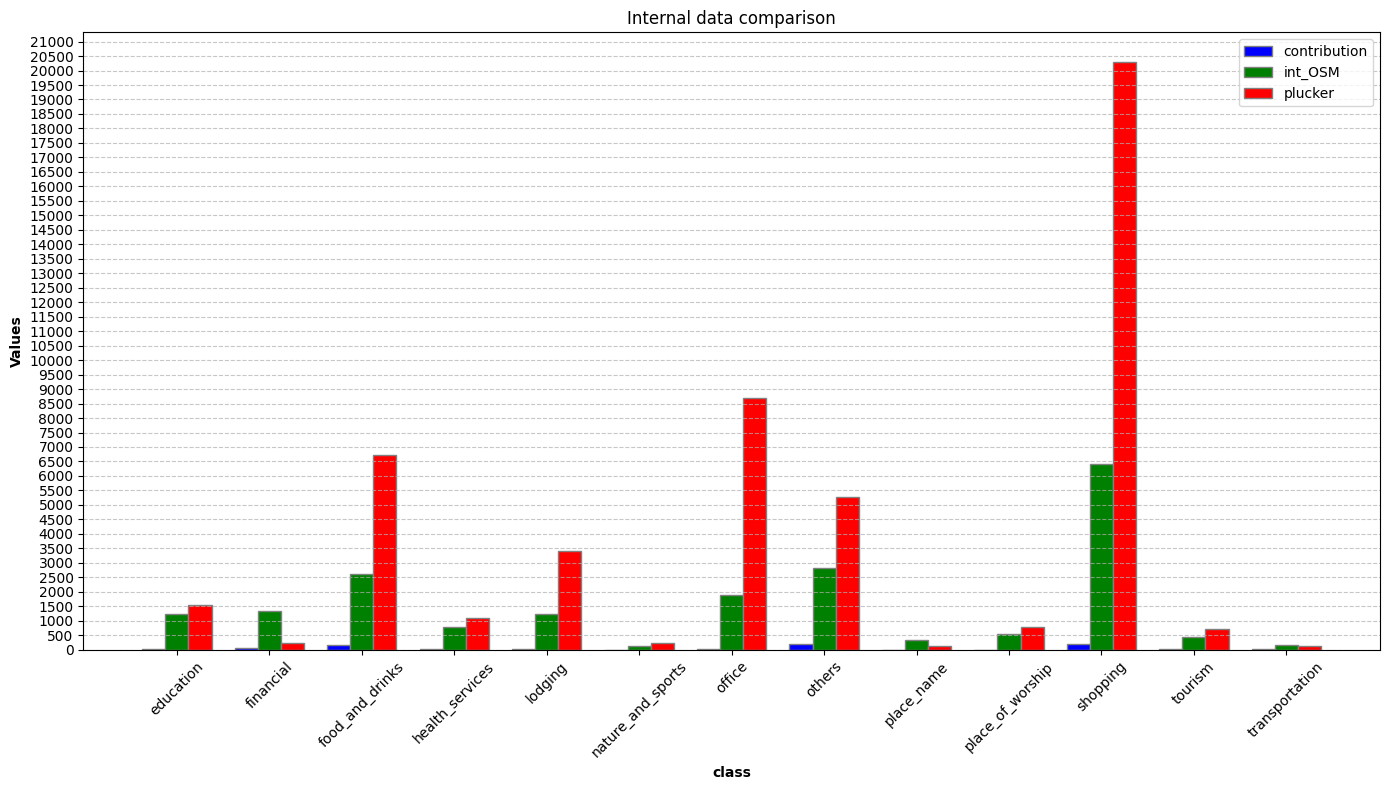

In [ ]:
bar_width = 0.25
r1 = np.arange(len(transposed_df_reset['int_OSM']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
plt.figure(figsize=(14, 8))
plt.bar(r1, transposed_df_reset['contribution'], color='b', width=bar_width, edgecolor='grey', label='contribution')
plt.bar(r2, transposed_df_reset['int_OSM'], color='g', width=bar_width, edgecolor='grey', label='int_OSM')
plt.bar(r3, transposed_df_reset['plucker'], color='r', width=bar_width, edgecolor='grey', label='plucker')
plt.xlabel('class', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(transposed_df_reset['class']))], transposed_df_reset['class'], rotation=45)
plt.ylabel('Values', fontweight='bold')
plt.title('Internal data comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.yticks(np.arange(0, max(transposed_df[['contribution', 'int_OSM', 'plucker']].values.max(axis=1)) + 1000, 500))
plt.savefig('internal_comparison.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

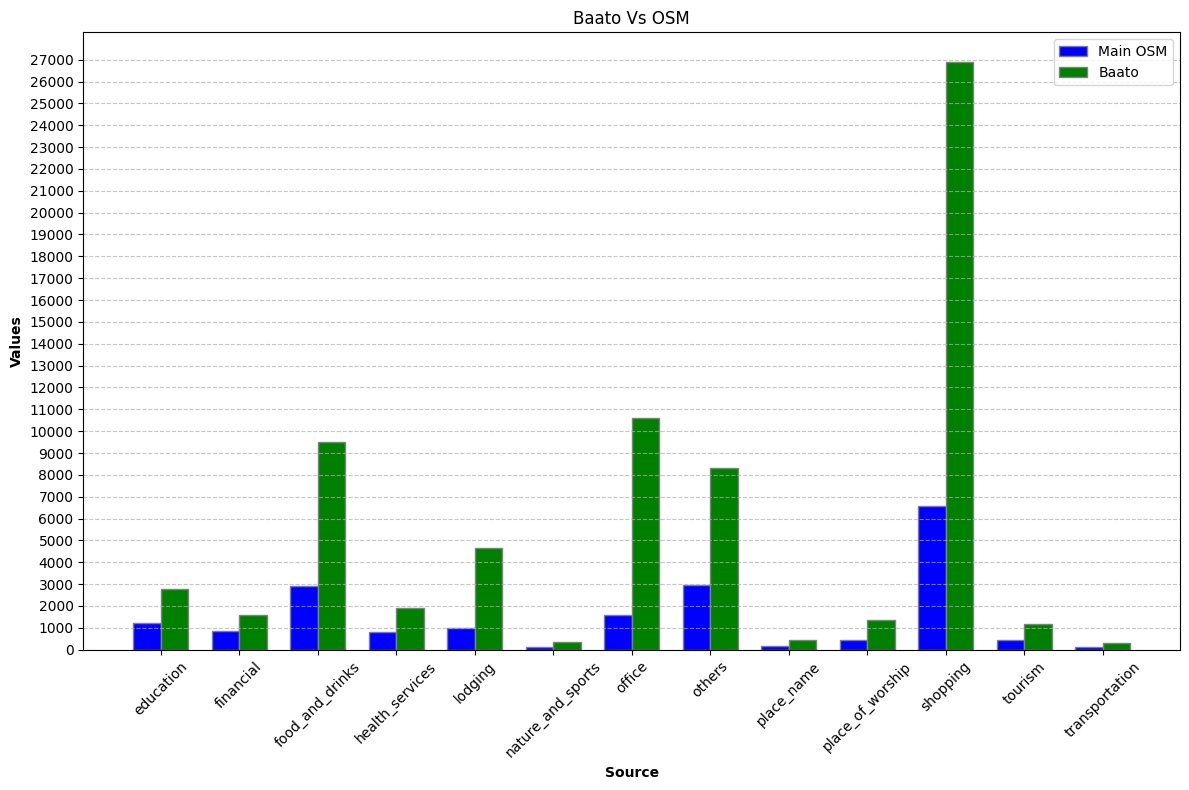

In [ ]:
columns_to_plot = ['OSM', 'internal']

bar_width = 0.35
r1 = np.arange(len(transposed_df_reset['class']))
r2 = [x + bar_width for x in r1]
plt.figure(figsize=(12, 8))
plt.bar(r1, transposed_df_reset['OSM'], color='b', width=bar_width, edgecolor='grey', label='Main OSM')
plt.bar(r2, transposed_df_reset['internal'], color='g', width=bar_width, edgecolor='grey', label='Baato')
plt.xlabel('Source', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(transposed_df_reset['class']))], transposed_df_reset['class'], rotation=45)
plt.ylabel('Values', fontweight='bold')
plt.title('Baato Vs OSM')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.yticks(np.arange(0, max(transposed_df_reset[['OSM', 'internal']].values.max(axis=1)) + 1000, 1000))
plt.savefig('BaatoVsOSM.png', bbox_inches='tight')
plt.tight_layout()
plt.show()